In [1]:
from datascience import *
import numpy as np
import matplotlib
from mpl_toolkits.mplot3d import Axes3D
%matplotlib inline
import matplotlib.pyplot as plots
plots.style.use('fivethirtyeight')

### Multiple regression

We'll illustrate multiple linear regression using a toy "Zillow competition" problem, using a data set of house sales in Ames, Iowa. This example parallels 
the treatment in [Chapter 17.6](https://www.inferentialthinking.com/chapters/17/6/Multiple_Regression.html) of the book.


In [2]:
all_sales = Table.read_table('house.csv')
sales = all_sales.where('Bldg Type', '1Fam').where('Sale Condition', 'Normal').select(
    'SalePrice', '1st Flr SF', '2nd Flr SF', 
    'Total Bsmt SF', 'Garage Area', 
    'Wood Deck SF', 'Open Porch SF', 'Lot Area', 
    'Year Built', 'Yr Sold')
sales.sort('SalePrice')

SalePrice,1st Flr SF,2nd Flr SF,Total Bsmt SF,Garage Area,Wood Deck SF,Open Porch SF,Lot Area,Year Built,Yr Sold
35000,498,0,498,216,0,0,8088,1922,2006
39300,334,0,0,0,0,0,5000,1946,2007
40000,649,668,649,250,0,54,8500,1920,2008
45000,612,0,0,308,0,0,5925,1940,2009
52000,729,0,270,0,0,0,4130,1935,2008
52500,693,0,693,0,0,20,4118,1941,2006
55000,723,363,723,400,0,24,11340,1920,2008
55000,796,0,796,0,0,0,3636,1922,2008
57625,810,0,0,280,119,24,21780,1910,2009
58500,864,0,864,200,0,0,8212,1914,2010


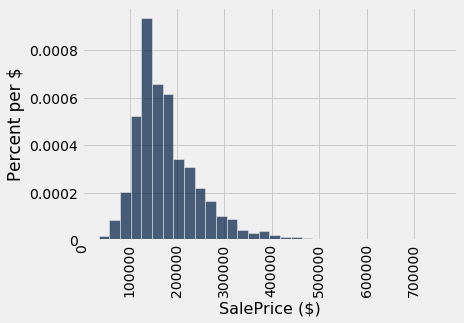

In [3]:
sales.hist('SalePrice', bins=32, unit='$')

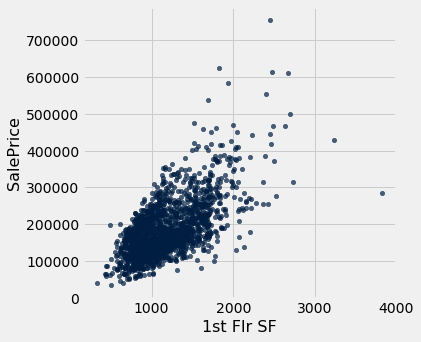

In [4]:
sales.scatter('1st Flr SF', 'SalePrice')

In [5]:
def standardize(x):
    return (x-np.mean(x))/np.std(x)

def correlation(t, col1, col2):
    x = standardize(t.column(col1))
    y = standardize(t.column(col2))
    return np.mean(x*y)


In [6]:
correlation(sales, 'SalePrice', '1st Flr SF')

0.6424662541030225

In [7]:
r = make_array()
for label in sales.labels:
    r = np.append(r, correlation(sales, label, 'SalePrice'))

corr_table = Table().with_columns('Attribute', sales.labels, 'Correlation with Sale Price', r)
corr_table

Attribute,Correlation with Sale Price
SalePrice,1
1st Flr SF,0.642466
2nd Flr SF,0.357522
Total Bsmt SF,0.652979
Garage Area,0.638594
Wood Deck SF,0.352699
Open Porch SF,0.336909
Lot Area,0.290823
Year Built,0.565165
Yr Sold,0.0259486


-0.2305611808841421


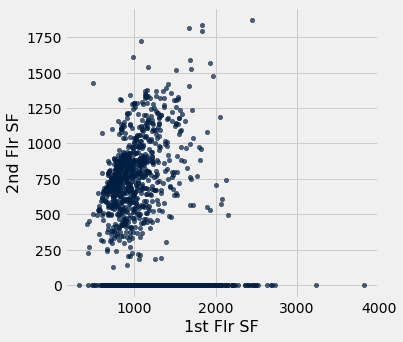

In [8]:
sales.scatter('1st Flr SF', '2nd Flr SF')
print(correlation(sales, '2nd Flr SF', '1st Flr SF'))

In [9]:
both_floors = sales.column(1) + sales.column(2)
correlation(sales.with_column('Both Floors', both_floors), 'SalePrice', 'Both Floors')


0.7821920556134877

In [10]:
sales = sales.with_column('one', np.ones(sales.num_rows))
sales

SalePrice,1st Flr SF,2nd Flr SF,Total Bsmt SF,Garage Area,Wood Deck SF,Open Porch SF,Lot Area,Year Built,Yr Sold,one
215000,1656,0,1080,528,210,62,31770,1960,2010,1
105000,896,0,882,730,140,0,11622,1961,2010,1
172000,1329,0,1329,312,393,36,14267,1958,2010,1
244000,2110,0,2110,522,0,0,11160,1968,2010,1
189900,928,701,928,482,212,34,13830,1997,2010,1
195500,926,678,926,470,360,36,9978,1998,2010,1
189000,1028,776,994,442,140,60,7500,1999,2010,1
175900,763,892,763,440,157,84,10000,1993,2010,1
185000,1187,0,1168,420,483,21,7980,1992,2010,1
180400,789,676,789,393,0,75,8402,1998,2010,1


In [11]:
train, test = sales.split(1001)
print(train.num_rows, 'training and', test.num_rows, 'test instances.')

1001 training and 1001 test instances.


In [12]:
def predict(slopes, row):
    return sum(slopes * np.array(row))

example_row = test.drop('SalePrice').row(0)
print('Predicting sale price for:\n', example_row)

example_slopes = np.random.normal(10, 1, len(example_row))
print('\nUsing slopes\n:', example_slopes)
print('\nResult:', predict(example_slopes, example_row))

Predicting sale price for:
 Row(1st Flr SF=926, 2nd Flr SF=0, Total Bsmt SF=902.0, Garage Area=351.0, Wood Deck SF=319, Open Porch SF=0, Lot Area=9750, Year Built=1977, Yr Sold=2009, one=1.0)

Using slopes
: [11.28235823 10.25268769  9.42603666  9.33377656  9.33531636 10.22391463
  9.14437312 10.54680919  9.57233273  9.44381065]

Result: 154452.81026289734


In [13]:
print('Actual sale price:', test.column('SalePrice').item(0))
print('Predicted sale price using random slopes:', predict(example_slopes, example_row))

Actual sale price: 156450
Predicted sale price using random slopes: 154452.81026289734


In [14]:
train_prices = train.column(0)
train_attributes = train.drop(0)

def rmse(slopes, attributes, prices):
    errors = []
    for i in np.arange(len(prices)):
        predicted = predict(slopes, attributes.row(i))
        actual = prices.item(i)
        errors.append((predicted - actual) ** 2)
    return np.mean(errors) ** 0.5

def rmse_train(slopes):
    return rmse(slopes, train_attributes, train_prices)

print('RMSE of all training examples using random slopes: $%.2f' % rmse_train(example_slopes))

RMSE of all training examples using random slopes: $66243.22


In [15]:
best_slopes = minimize(rmse_train, start=example_slopes, smooth=True, array=True)
print('The best slopes for the training set:')
Table(train_attributes.labels).with_row(list(best_slopes)).show()
print('RMSE of all training examples using the best slopes: $%.2f' % rmse_train(best_slopes))

The best slopes for the training set:


1st Flr SF,2nd Flr SF,Total Bsmt SF,Garage Area,Wood Deck SF,Open Porch SF,Lot Area,Year Built,Yr Sold,one
77.1177,75.765,56.0348,51.2655,28.9752,8.61565,0.30538,487.496,-488.924,9.178


RMSE of all training examples using the best slopes: $30971.45


In [16]:
test_prices = test.column(0)
test_attributes = test.drop(0)

def rmse_test(slopes):
    return rmse(slopes, test_attributes, test_prices)

rmse_linear = rmse_test(best_slopes)
print('Test set RMSE for multiple linear regression: $%.2f'% rmse_linear)

Test set RMSE for multiple linear regression: $31477.36


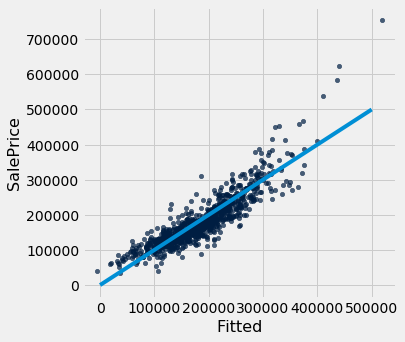

In [17]:
def fit(row):
    return sum(best_slopes * np.array(row))

test.with_column('Fitted', test.drop(0).apply(fit)).scatter('Fitted', 0)
plots.plot([0, 5e5], [0, 5e5]);

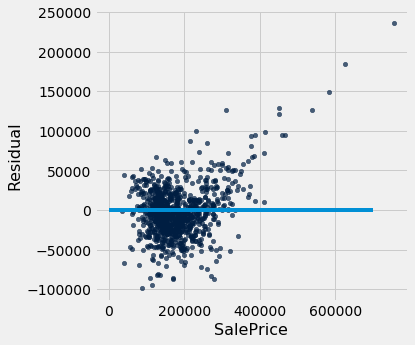

In [18]:
test.with_column('Residual', test_prices-test.drop(0).apply(fit)).scatter(0, 'Residual')
plots.plot([0, 7e5], [0, 0]);

In [19]:
train_nn = train.select(0, 1, 2, 3, 4, 8)
test_nn = test.select(0, 1, 2, 3, 4, 8)
train_nn.show(3)

SalePrice,1st Flr SF,2nd Flr SF,Total Bsmt SF,Garage Area,Year Built
196000,1676,0,1160,672,1977
169900,1034,0,1012,888,1976
179900,1234,0,1234,484,2007


In [20]:
def distance(pt1, pt2):
    """The distance between two points, represented as arrays."""
    return np.sqrt(sum((pt1 - pt2) ** 2))

def row_distance(row1, row2):
    """The distance between two rows of a table."""
    return distance(np.array(row1), np.array(row2))

def distances(training, example, output):
    """Compute the distance from example for each row in training."""
    dists = []
    attributes = training.drop(output)
    for row in attributes.rows:
        dists.append(row_distance(row, example))
    return training.with_column('Distance', dists)

def closest(training, example, k, output):
    """Return a table of the k closest neighbors to example."""
    return distances(training, example, output).sort('Distance').take(np.arange(k))



In [21]:
example_nn_row = test_nn.drop(0).row(0)
print(test_nn.row(0))
closest(train_nn, example_nn_row, 5, 'SalePrice')

Row(SalePrice=156450, 1st Flr SF=926, 2nd Flr SF=0, Total Bsmt SF=902.0, Garage Area=351.0, Year Built=1977)


SalePrice,1st Flr SF,2nd Flr SF,Total Bsmt SF,Garage Area,Year Built,Distance
140000,907,0,907,343,1978,21.2368
144000,912,0,912,352,1962,22.8473
132000,934,0,912,336,1964,23.622
125000,912,0,912,336,1967,24.9199
129000,912,0,912,315,1966,41.3884


In [22]:
def predict_nn(example):
    """Return the majority class among the k nearest neighbors."""
    return np.average(closest(train_nn, example, 5, 'SalePrice').column('SalePrice'))

predict_nn(example_nn_row)

134000.0

In [23]:
print('Actual sale price:', test_nn.column('SalePrice').item(0))
print('Predicted sale price using nearest neighbors:', predict_nn(example_nn_row))

Actual sale price: 156450
Predicted sale price using nearest neighbors: 134000.0


In [24]:
nn_test_predictions = test_nn.drop('SalePrice').apply(predict_nn)
rmse_nn = np.mean((test_prices - nn_test_predictions) ** 2) ** 0.5

print('Test set RMSE for multiple linear regression: $%.2f' % rmse_linear)
print('Test set RMSE for nearest neighbor regression: $%.2f' % rmse_nn)

Test set RMSE for multiple linear regression: $31477.36
Test set RMSE for nearest neighbor regression: $34789.18


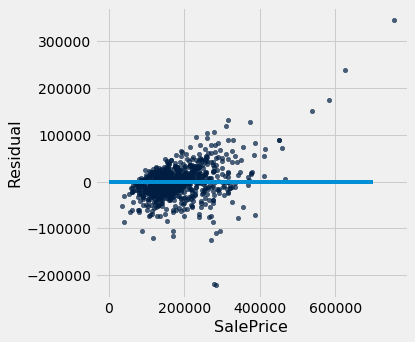

In [25]:
test.with_column('Residual', test_prices-nn_test_predictions).scatter(0, 'Residual')
plots.plot([0, 7e5], [0, 0]);